# PIV analysis

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 9

In [2]:
#import json
#from scipy import stats
#import scipy.interpolate as interp
#import sys
#sys.path.append('/home/claudio/Documents/Atos/pyModules')

In [3]:
from skimage import io
from skimage import exposure
from skimage.morphology import disk
from skimage.filters.rank import maximum, minimum
from skimage.filters import gaussian
from skimage import img_as_ubyte, img_as_float
from skimage.feature import register_translation

## Read images

In [4]:
im_a = io.imread('./images/naca23012_dinamico_24deg_fin1_1_a.bmp', as_grey=True)
im_b = io.imread('./images/naca23012_dinamico_24deg_fin1_1_b.bmp', as_grey=True)

In [5]:
img = [[im_a, 'Image A'], [im_b, 'Image B']]

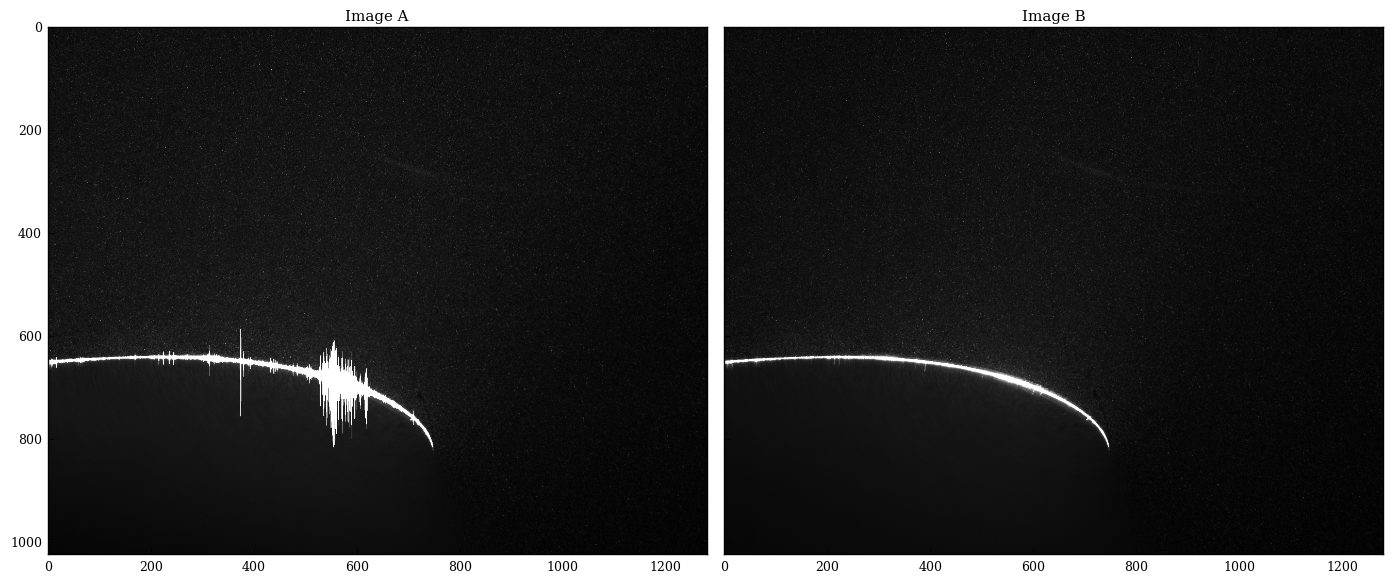

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for i in range(2):
    ax[i].imshow(img[i][0], cmap=plt.cm.gray)
    ax[i].set_title(img[i][1])

#for a in ax.ravel():
#    a.axis('off')

fig.tight_layout()

Size of images

In [7]:
im_a.shape

(1024, 1280)

# Preprocess

## Histogram

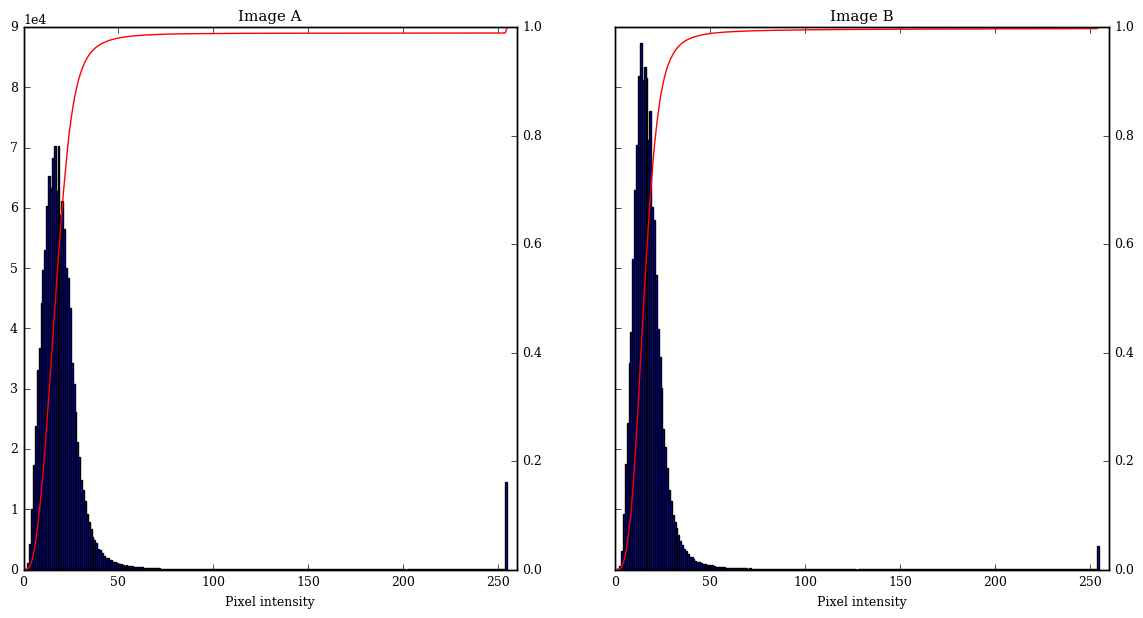

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
bins = 256



for i in range(2):
    ax_cdf = ax[i].twinx()
    ax[i].hist(img[i][0].ravel(), bins=bins)
    ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax[i].set_xlabel('Pixel intensity')
    ax[i].set_xlim(0, 260)
    ax[i].set_title(img[i][1])
    img_cdf, bins1 = exposure.cumulative_distribution(img[i][0], bins)
    ax_cdf.plot(bins1, img_cdf, 'r')


## Min Max Filter

In [9]:
img_f = []

for i in range(2):
    ul = maximum(img[i][0], disk(5))
    #ul = gaussian(ul, sigma=1. , mode='constant')
    il = minimum(img[i][0], disk(5))
    #il = gaussian(il, sigma=1. , mode='constant')
    img[i].append((img[i][0] - il)/(ul - il))

/home/claudio/.local/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in divide


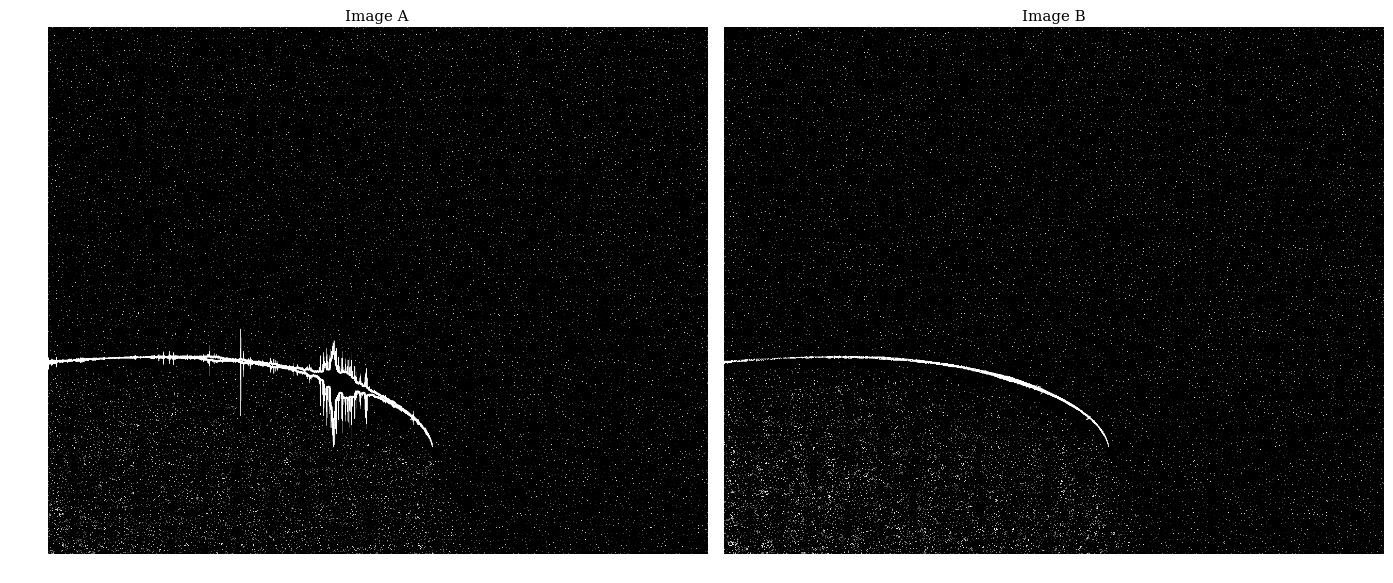

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()

for i in range(2):
    ax[i].imshow(img[i][2], cmap=plt.cm.gray)
    ax[i].set_title(img[i][1])

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

## Histogram
compute histograms of filtered images

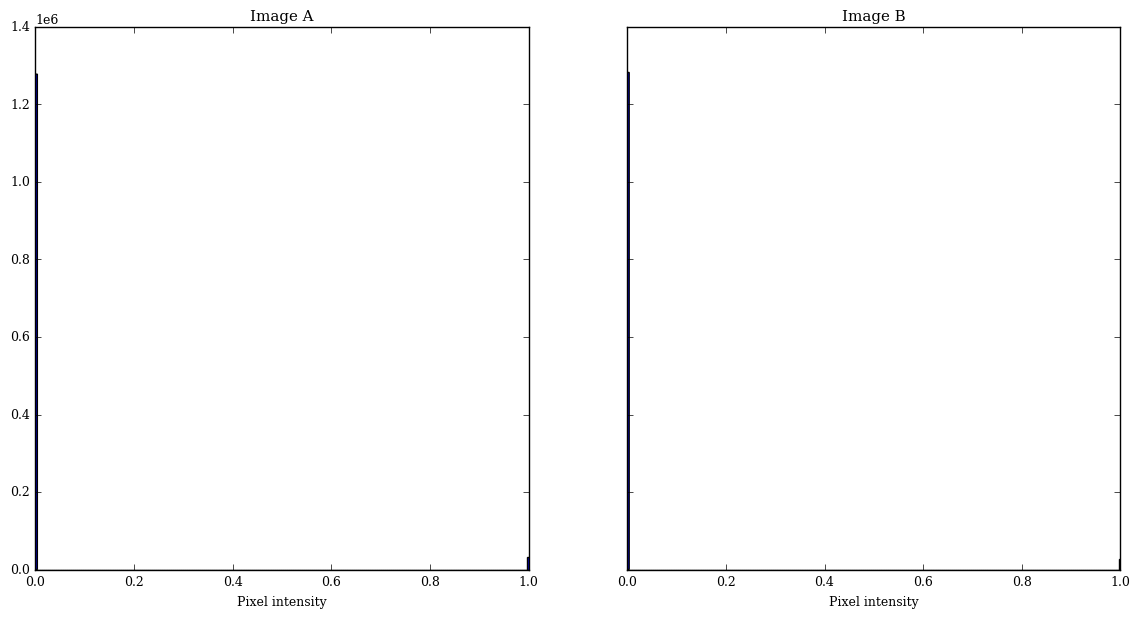

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True, subplot_kw={'adjustable': 'box-forced'})
ax = axes.ravel()
bins = 256



for i in range(2):
    #ax_cdf = ax[i].twinx()
    ax[i].hist(img[i][2].ravel(), bins=bins)
    ax[i].ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax[i].set_xlabel('Pixel intensity')
    #ax[i].set_xlim(0, 260)
    ax[i].set_title(img[i][1])
    #img_cdf, bins1 = exposure.cumulative_distribution(img[i][2], bins)
    #ax_cdf.plot(bins1, img_cdf, 'r')


# Correlation

Naive correlation

In [12]:
window_size = 32
max_ext = 16

In [13]:
def corr_wind(im_a,im_b,window_size, max_ext,y0,x0):
    
    corr_mat = np.zeros((2*max_ext+1,2*max_ext+1))
    
    for j in range(-max_ext,max_ext+1):
        for i in range(-max_ext,max_ext+1):
            corr_mat[j+max_ext,i+max_ext] = np.sum(im_a[y0+j:y0+j+window_size,x0+i:x0+i+window_size]*
                                                   im_b[y0:y0+window_size,x0:x0+window_size])
    
    return corr_mat

In [14]:
def find_max_corr(corr_matrix, subpixel=False):
    i,j = np.unravel_index(corr_matrix.argmax(), corr_matrix.shape)
    return i,j

In [15]:
def corr_wind_SK(im_a,im_b,window_size, max_ext,y0,x0):
    shift, error, diffphase = register_translation(im_a[y0:y0+window_size,x0:x0+window_size], 
                                                   im_b[y0:y0+window_size,x0:x0+window_size])
    
    #print error
    
    return shift

In [16]:
dim_y, dim_x = img[0][0].shape

n_wind_x = (dim_x-2*max_ext)/window_size
n_wind_y = (dim_y-2*max_ext)/window_size

In [17]:
corr_data = []

for y0 in range(max_ext,dim_y-max_ext-window_size,window_size):
    for x0 in range(max_ext,dim_x-max_ext-window_size,window_size):
        xc = x0+window_size/2
        yc = y0+window_size/2
        #print xc,yc
        #corr_m = corr_wind(img[0][0],img[1][0],window_size,max_ext,y0,x0)
        #dy,dx = find_max_corr(corr_m)
        #corr_data.append([yc,xc,dy-max_ext, dx-max_ext])
        
        shift = corr_wind_SK(img[0][0],img[1][0],window_size,max_ext,y0,x0)
        corr_data.append([yc,xc,-shift[0], -shift[1]])

In [18]:
#corr_data

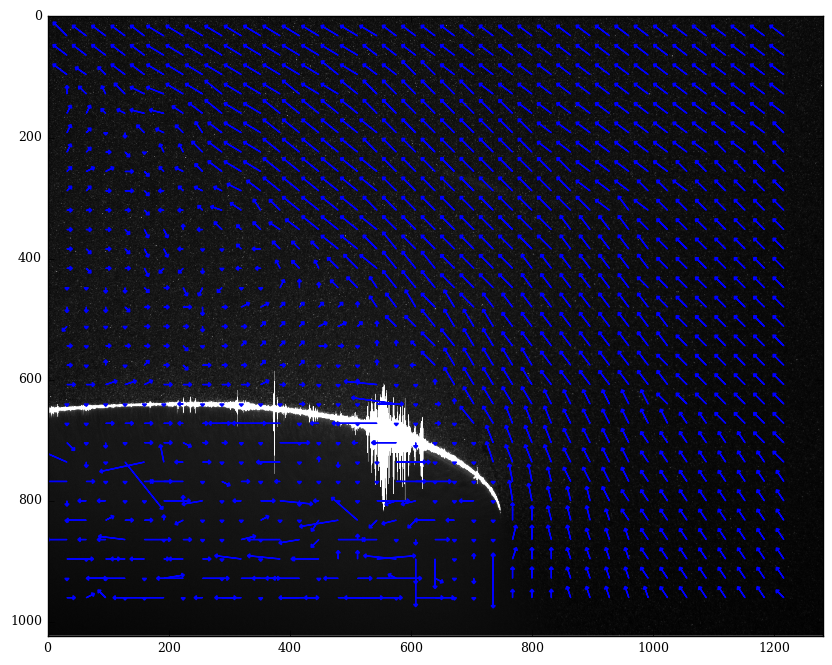

In [19]:
#d = corr_data[0]

plt.figure(figsize=(10,8))
plt.imshow(img[0][0], cmap=plt.cm.gray)
for d in corr_data:#[:4]:
    plt.arrow(d[1],d[0],5*d[3],5*d[2], head_width=7, head_length=4, fc='b', ec='b')

#plt.gca().invert_yaxis()
plt.xlim([0,dim_x])
plt.ylim([0,dim_y])
plt.ylim(plt.ylim()[::-1]);